# Unit 5: Model-based Collaborative Filtering for **Rating** Prediction

In this unit, we change the approach towards CF from neighborhood-based to **model-based**. This means that we create and train a model for describing users and items instead of using the k nearest neighbors. The model parameters are latent representations for users and items.

Key to this idea is to compress the sparse interaction information of $R$ by finding two matrices $U$ and $V$ that by multiplication reconstruct $R$. The decomposition of $R$ into $U \times V$ is called _matrix factorization_ and we refer to $U$ as user latent factor matrix and $V$ as item latent factor matrix. In addition to the dot product of user and item latent factors we also model user- and item-specific biases. This reflects the intuitive understanding of some users being more critical and some items being systematically rated better or worse, e.g. due to popularity. Among these biases, we also estimate the global mean $\mu$ as the overall average rating.

Compressing the sparse matrix into the product of two matrices means that the two remaining matrices are much smaller. This decrease in size is governed by the dimension of latent user/item vectors and symbolized by $d \in \mathbb{N}$. We choose $d$ to be much smaller than the number of items or users:

\begin{equation*}
\underset{m\times n}{\mathrm{R}} \approx  \underset{m\times d}{U} \times \underset{d\times n}{V^T} \\
d \ll \min\{m, n\} \\
\hat{r}_{ij} = \mu + b_i + b_j + u_i^{T} \cdot v_j \\
\mu, b_i, b_j \in \mathbb{R}
\end{equation*}

In [64]:
from collections import OrderedDict
import itertools
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [65]:
from recsys_training.data import Dataset
from recsys_training.evaluation import get_relevant_items

In [66]:
ml100k_ratings_filepath = '../../data/raw/ml-100k/u.data'

## Config

In [67]:
seed = 49
d = 40
model_biases = True

## Load Data

In [68]:
data = Dataset(ml100k_ratings_filepath)
data.rating_split(seed=seed)
user_ratings = data.get_user_ratings()

m = data.n_users
n = data.n_items

## Initialize the user and item latent factors, i.e. the model parameters

As we want to learn the user/item latent factors from rating data, we first randomly initialize them

In [111]:
np.random.seed(seed)

user_factors = np.random.normal(0, .1, (m, d))
item_factors = np.random.normal(0, .1, (n, d))

if model_biases:
    user_biases = np.random.normal(0, .1, (m, 1))
    item_biases = np.random.normal(0, .1, (n, 1))
else:
    user_biases = None
    item_biases = None

In [112]:
ratings = data.train_ratings[['user', 'item', 'rating']].sample(frac=1, random_state=seed)

In [113]:
global_mean = ratings["rating"].mean()
global_mean

3.5304375

$u_1^{T} \cdot v_{223}$

In [114]:
np.dot(user_factors[1], item_factors[233])

-0.12336546162571498

In [115]:
model_variables = {
    "user_factors": user_factors,
    "item_factors": item_factors,
    "user_biases": user_biases,
    "item_biases": item_biases,
    "global_mean": global_mean
}

## Prediction and Gradient Computation

![](../Parrot.png)

**Task:** Implement a function `predict` that takes as input the latent factors for users, items and the biases to return the corresponding rating predictions

In [116]:
def predict(model_variables: dict, user_idxs: np.array, item_idxs: np.array) -> np.array:
    """
    return Bx1 array where B is the number of ratings to be predicted
    """
    user_factors = model_variables["user_factors"][user_idxs]
    item_factors = model_variables["item_factors"][item_idxs]
    
    r_hat = np.sum(user_factors*item_factors, axis=1)
    
    if model_variables["user_biases"] is not None:
        r_hat += model_variables["user_biases"][user_idxs].flatten()
    if model_variables["item_biases"] is not None:
        r_hat += model_variables["item_biases"][item_idxs].flatten()
    if model_variables["global_mean"] is not None:
        r_hat += global_mean
    
    return r_hat

![](../Parrot.png)

**Task:** Implement `compute_gradients` that receives a minibatch and computes the gradients for user and item latent vectors involved.

$\sum_{r_{ij} \in D}(r_{ij} - \hat{r}_{ij}) + \lambda(b_i^{2}+b_u^{2}+||q_i||^{2}+||p_u||^{2})$

Gradient Updates for biases

* $b_i = b_i + \alpha(e_{ij}-\lambda{b_i})$
* $b_j = b_j + \alpha(e_{ij}-\lambda{b_j})$

Gradient Updates for latent factors

* $u_i = u_i+\alpha(e_{ij}\cdot{v_j}-\lambda{u_i})$
* $v_j = v_j+\alpha(e_{ij}\cdot{u_i}-\lambda{v_j})$

In [117]:
def compute_gradients(error: np.array,
                      user_idxs: np.array,
                      item_idxs: np.array,
                      model_variables: dict,
                      reg_rate: float = 0.02) -> Dict[str, np.array]:
    
    user_factors = model_variables["user_factors"][user_idxs]
    item_factors = model_variables["item_factors"][item_idxs]
    
    gradients = {}
    gradients["user_factors"] = error*item_factors - reg_rate*user_factors
    gradients["item_factors"] = error*user_factors - reg_rate*item_factors
    
    if model_variables["user_biases"] is not None:
        gradients["user_biases"] = error - reg_rate*model_variables["user_biases"][user_idxs]
    
    if model_variables["item_biases"] is not None:
        gradients["item_biases"] = error - reg_rate*model_variables["item_biases"][item_idxs]
    
    return gradients

## Training

We fit the model to the data with a technique called _minibatch gradient descent_.

This means that for a number of epochs, i.e. full passes through the training data (ratings), we randomly choose a small subset of ratings (our minibatch) holding user, item and rating for each instance. Then, we compute the rating prediction as the dot product of user and item latent vectors (also called embeddings) and compute the mean squared error between predicted and true rating. We derive this error for user and item latent vectors to obtain our partial derivatives. We subtract part of the gradient from our latent vectors to move into the direction of minimizing error, i.e. deviation between true values and predictions.

To keep track of the decreasing error, we compute the root mean squared error and print it.

In [118]:
epochs = 15
batch_size = 64
learning_rate = 0.01
reg_rate = 0.01

num_batches = int(np.ceil(len(ratings) / batch_size))
train_rmse_trace = []
test_rmse_trace = []

In [119]:
for epoch in range(epochs):
    for idx in range(num_batches):
        
        minibatch = ratings.iloc[idx * batch_size:(idx + 1) * batch_size]
        
        user_idxs = (minibatch["user"].values - 1)
        item_idxs = (minibatch["item"].values - 1)
        
        # Generate Rating Predictions
        preds = predict(model_variables, user_idxs, item_idxs)
        
        # Compute Error
        error = (minibatch['rating'].values - preds).reshape(-1, 1)
        
        # Compute Gradients
        gradients = compute_gradients(error,
                                      user_idxs,
                                      item_idxs,
                                      model_variables,
                                      reg_rate=reg_rate)
        
        # Perform Update Step, i.e. apply gradients to model variables
        model_variables["user_factors"][user_idxs] += learning_rate*gradients["user_factors"]
        model_variables["item_factors"][item_idxs] += learning_rate*gradients["item_factors"]
        if model_biases:
            model_variables["user_biases"][user_idxs] += learning_rate*gradients["user_biases"]
            model_variables["item_biases"][item_idxs] += learning_rate*gradients["item_biases"]
        
        if not idx % 300:
            train_rmse = np.sqrt(np.mean(error ** 2))
            
            user_idxs = (data.test_ratings['user'].values - 1)
            item_idxs = (data.test_ratings['item'].values - 1)
            
            test_predictions = predict(model_variables, user_idxs, item_idxs)
            
            test_error = (data.test_ratings['rating'].values - test_predictions).reshape(-1, 1)
            test_rmse = np.sqrt(np.mean(test_error ** 2))
            
            train_rmse_trace.append(train_rmse)
            test_rmse_trace.append(test_rmse)
            print(f"Epoch: {epoch:02d} - Batch: {idx:04d}, Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")

Epoch: 00 - Batch: 0000, Train RMSE: 1.305, Test RMSE: 1.141
Epoch: 00 - Batch: 0300, Train RMSE: 0.946, Test RMSE: 1.058
Epoch: 00 - Batch: 0600, Train RMSE: 0.949, Test RMSE: 1.022
Epoch: 00 - Batch: 0900, Train RMSE: 1.077, Test RMSE: 1.002
Epoch: 00 - Batch: 1200, Train RMSE: 0.927, Test RMSE: 0.990
Epoch: 01 - Batch: 0000, Train RMSE: 1.125, Test RMSE: 0.988
Epoch: 01 - Batch: 0300, Train RMSE: 0.801, Test RMSE: 0.982
Epoch: 01 - Batch: 0600, Train RMSE: 0.870, Test RMSE: 0.977
Epoch: 01 - Batch: 0900, Train RMSE: 1.082, Test RMSE: 0.972
Epoch: 01 - Batch: 1200, Train RMSE: 0.887, Test RMSE: 0.969
Epoch: 02 - Batch: 0000, Train RMSE: 1.082, Test RMSE: 0.968
Epoch: 02 - Batch: 0300, Train RMSE: 0.778, Test RMSE: 0.966
Epoch: 02 - Batch: 0600, Train RMSE: 0.845, Test RMSE: 0.964
Epoch: 02 - Batch: 0900, Train RMSE: 1.074, Test RMSE: 0.962
Epoch: 02 - Batch: 1200, Train RMSE: 0.867, Test RMSE: 0.961
Epoch: 03 - Batch: 0000, Train RMSE: 1.060, Test RMSE: 0.960
Epoch: 03 - Batch: 0300,

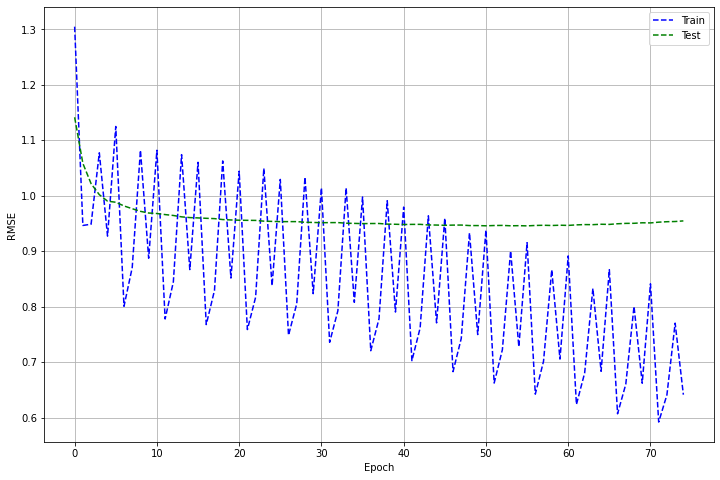

In [120]:
plt.figure(figsize=(12,8))
plt.plot(range(len(train_rmse_trace)), train_rmse_trace, 'b--', label='Train')
plt.plot(range(len(test_rmse_trace)), test_rmse_trace, 'g--', label='Test')
plt.grid(True)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

### Using the model for Recommendations

We have now created a model to describe users and items in terms of latent vectors. We fitted them to reconstruct ratings by multiplication. So for obtaining recommendations we simply multiply user-item latent vectors we are interested in and see favorable combinations where predicted ratings, i.e. the products, are rather high.

Thus, before writing the `get_recommendations` we first implement `get_prediction`.

![](../Parrot.png)

**Task:** Implement `get_prediction` for predicting ratings for a user and all items or a set of provided items. Remember to remove _known positives_.

In [121]:
def get_prediction(user: int,
                   model_variables: dict,
                   user_ratings: Dict[int, Dict[int, float]] = user_ratings,
                   items: np.array = None,
                   data: object = data,
                   remove_known_pos: bool = True) -> Dict[int, Dict[str, float]]:
    if items is None:
        if remove_known_pos:
            # Predict from unobserved items
            known_items = np.array(list(user_ratings[user].keys()))
            items = np.setdiff1d(data.items, known_items)
        else:
            items = np.array(data.items)
    if type(items) == np.int64:
        items = np.array([items])
    
    user_embed = user_factors[user - 1].reshape(1, -1)
    item_embeds = item_factors[items - 1].reshape(len(items), -1)
    
    # use array-broadcasting
    item_idxs = (items - 1)
    
    preds = predict(model_variables, np.array([user-1]), item_idxs)
    
    sorting = np.argsort(preds)[::-1]
    preds = {item: {'pred': pred} for item, pred in
             zip(items[sorting], preds[sorting])}

    return preds

In [122]:
item_predictions = get_prediction(1, model_variables)

In [123]:
list(item_predictions.items())[:10]

[(408, {'pred': 5.2480594734673085}),
 (96, {'pred': 5.119165625803175}),
 (276, {'pred': 5.115088111664335}),
 (483, {'pred': 4.915750082559056}),
 (515, {'pred': 4.864894261892342}),
 (603, {'pred': 4.817879660034034}),
 (126, {'pred': 4.758454694246811}),
 (513, {'pred': 4.748786974584198}),
 (484, {'pred': 4.710440872774363}),
 (963, {'pred': 4.7036876470773})]

In [124]:
def get_recommendations(user: int, N: int, model_variables: dict, remove_known_pos: bool = False) -> List[Tuple[int, Dict[str, float]]]:
    predictions = get_prediction(user, model_variables, remove_known_pos=remove_known_pos)
    recommendations = []
    for item, pred in predictions.items():
        add_item = (item, pred)
        recommendations.append(add_item)
        if len(recommendations) == N:
            break

    return recommendations

In [125]:
recommendations = get_recommendations(1, 10, model_variables)

In [126]:
recommendations

[(408, {'pred': 5.2480594734673085}),
 (172, {'pred': 5.23665859309333}),
 (96, {'pred': 5.119165625803175}),
 (276, {'pred': 5.115088111664335}),
 (14, {'pred': 5.110024258423135}),
 (56, {'pred': 5.050309825641344}),
 (89, {'pred': 5.024759145800694}),
 (258, {'pred': 4.9959063762769365}),
 (169, {'pred': 4.986145313265556}),
 (98, {'pred': 4.955668828807362})]

### Evaluation

In [127]:
N = 10

In [128]:
relevant_items = get_relevant_items(data.test_ratings)

In [129]:
users = relevant_items.keys()
prec_at_N = dict.fromkeys(data.users)

for user in users:
    recommendations = get_recommendations(user, N, model_variables, remove_known_pos=True)
    recommendations = [val[0] for val in recommendations]
    hits = np.intersect1d(recommendations,
                          relevant_items[user])
    prec_at_N[user] = len(hits)/N

In [130]:
recommendations

[178, 480, 134, 180, 269, 641, 357, 199, 168, 23]

In [131]:
np.mean([val for val in prec_at_N.values() if val is not None])

0.08981972428419936